For this implementation, I will be using an LSTM model. LSTMS are a special type of recurrent neural networks (RNN) which have the advantage of having feedback loops that function as memory, unlike other neural networks. Having no memory poses a problem when dealing with sequential data such as text or time series. LSTMs in particular have a long term and short term memory component, allowing us to deal with sequential data more effectively.

In [235]:
#Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

The "NVDA.csv" file contains NVDA daily stock prices over the last 5 years, starting from 23 October 2017 to 21 October 2022.

In [212]:
#Read in the data from the csv file containing NVDA stock price over the last 5 years
nvda = pd.read_csv("../input/nvidia-stock-price/NVDA.csv")
nvda.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-23,49.445000,49.712502,48.950001,49.154999,48.637699,42869600
1,2017-10-24,49.247501,49.687500,48.985001,49.669998,49.147301,40724400
2,2017-10-25,49.270000,49.805000,47.792500,48.415001,47.905502,82816000
3,2017-10-26,48.695000,49.040001,48.452499,48.922501,48.407658,32274400
4,2017-10-27,49.450001,50.467499,49.187500,50.465000,49.933922,57219200


We first split the data into train and test data.

In [238]:
train_data, test_data = train_test_split(nvda, test_size=0.2,shuffle=False)

# We will use the close price in our model
train_set = train_data.iloc[:,4:5].values

print(train_set)
print(train_set.shape)

[[ 49.154999]
 [ 49.669998]
 [ 48.415001]
 ...
 [222.899994]
 [221.029999]
 [226.919998]]
(1007, 1)


Next, the close prices for the training set are scaled to a range of (0,1) through normalization to ensure more effective computation.

In [239]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_training_set = scaler.fit_transform(train_set)

scaled_training_set

array([[0.0884013 ],
       [0.09102003],
       [0.08463847],
       ...,
       [0.97188041],
       [0.96237163],
       [0.9923218 ]])

The model will use the stock prices over the past 60 days to predict the close price for the 61st day. In order to do this, I create two variables X_train and y_train. The ith element of y_train is a close price, whereas the ith element of x_train is a list of the close prices over the last 60 days which corresponds to the ith element of y_train.

In [241]:
X_train = []
y_train = []

for i in range(60, len(scaled_training_set)):
    X_train.append(scaled_training_set[i-60 : i, 0])
    y_train.append(scaled_training_set[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)


print("X_train: ", X_train)
print("y_train: ", y_train)
# print(X_train.shape)
# print(y_train.shape)

X_train:  [[0.0884013  0.09102003 0.08463847 ... 0.11826249 0.12412286 0.12376692]
 [0.09102003 0.08463847 0.08721907 ... 0.12412286 0.12376692 0.13097478]
 [0.08463847 0.08721907 0.09506255 ... 0.12376692 0.13097478 0.13552579]
 ...
 [0.81953629 0.81516327 0.83016376 ... 0.94421852 0.95011696 0.9684227 ]
 [0.81516327 0.83016376 0.83824876 ... 0.95011696 0.9684227  0.97188041]
 [0.83016376 0.83824876 0.82996039 ... 0.9684227  0.97188041 0.96237163]]
y_train:  [0.13097478 0.13552579 0.14216161 0.13820808 0.13890727 0.14778044
 0.15225518 0.14700499 0.15092038 0.14418286 0.13530968 0.1101139
 0.12521611 0.12930948 0.11497001 0.13347911 0.12833063 0.13417829
 0.14535239 0.15181024 0.14842876 0.15509001 0.1454668  0.14628038
 0.15108563 0.15191193 0.15125089 0.1460897  0.13364438 0.13914878
 0.13801739 0.1462931  0.1458863  0.14504728 0.1503229  0.15595444
 0.15334843 0.1546578  0.15542052 0.15686972 0.14481847 0.15572562
 0.15442896 0.14589903 0.1346105  0.14924235 0.12513984 0.11983882
 

Next, we reshape the data. Since we are using only the close price, the number of indicators is set to 1.

In [242]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(947, 60, 1)

In [244]:
#Import the packages for the model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Then, we initialize the LSTM model with 4 layers. We will initialize the number of neurons in each layer to 50 to satisfactorily capture the upward and downward trends. The dropout rate of 0.2 means that 10 neurons (20% of 50) will be ignored during each iteration.

In [245]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

Then we compile and fit the model, obtaining a loss of 9.8706e-04 at epochs = 10.

In [246]:
regressor.compile(optimizer ="adam", loss = "mean_squared_error")
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
30/30 [==============================] - 15s 207ms/step - loss: 0.0190
Epoch 2/10
30/30 [==============================] - 6s 213ms/step - loss: 0.0049
Epoch 3/10
30/30 [==============================] - 6s 208ms/step - loss: 0.0037
Epoch 4/10
30/30 [==============================] - 7s 219ms/step - loss: 0.0031
Epoch 5/10
30/30 [==============================] - 6s 207ms/step - loss: 0.0036
Epoch 6/10
30/30 [==============================] - 6s 203ms/step - loss: 0.0030
Epoch 7/10
30/30 [==============================] - 6s 197ms/step - loss: 0.0029
Epoch 8/10
30/30 [==============================] - 6s 200ms/step - loss: 0.0030
Epoch 9/10
30/30 [==============================] - 6s 217ms/step - loss: 0.0025
Epoch 10/10
30/30 [==============================] - 6s 200ms/step - loss: 0.0025


Next we in read the actual stock price from the test data.

In [248]:
actual_stock_price = test_data.iloc[:, 4:5].values

We follow by concatenating the train and test data for prediction as we need the price for the last 60 days of NVDA before the 1st date in the test data.

In [249]:
data_all = pd.concat((train_data["Close"],test_data["Close"]), axis = 0)

Create inputs for prediction. Reshape it to have only 1 column, scale by the training set.

In [250]:
inputs = data_all[len(data_all)-len(test_data)- 60: ].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [251]:
X_test = []

for i in range(60, len(inputs)): 
    X_test.append(inputs[i-60: i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, newshape = (X_test.shape[0],  
                    X_test.shape[1], 1))

In [252]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Visualization as below.

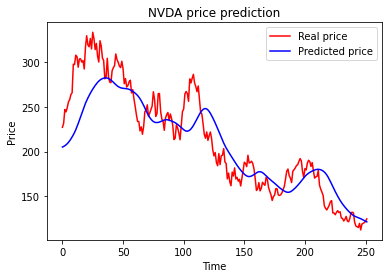

In [253]:
plt.plot(actual_stock_price, color = "red", label = "Real price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted price")
plt.title("NVDA price prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

The model is understandably late in picking up sharp trends such as a sudden decrease in price, which is understandable given the short time frame of the test data. However, it is still able to identify smoother trends. Now, we repeat the process for the new dates 24 October - 4 November.

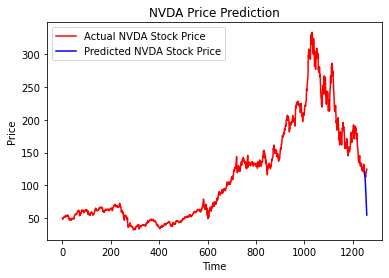

In [277]:
all_close = nvda['Close']
all_close = all_close.append(pd.Series([0]*12, index=pd.date_range(start='2022-10-24', periods=12, freq='D')))


new_inputs = all_close[len(all_close) - len(train_data) - 60 :].values
new_inputs = new_inputs.reshape(-1,1)
new_inputs = scaler.transform(new_inputs)

new_X_test = []

for i in range(60, len(new_inputs)):
    new_X_test.append(new_inputs[i-60 : i, 0])

new_X_test = np.array(new_X_test)
new_X_test = np.reshape(new_X_test, newshape = (new_X_test.shape[0], new_X_test.shape[1], 1))

new_pred_stock_price = regressor.predict(new_X_test)
new_pred_stock_price = scaler.inverse_transform(new_pred_stock_price)
new_pred_stock_price_last12 = new_pred_stock_price[-12:]

# Plot the results original data and predicted data
plt.plot(nvda["Close"], color = 'red', label = 'Actual NVDA Stock Price')
plt.plot(nvda["Close"].index[-12:], new_pred_stock_price_last12, color = 'blue',label = 'Predicted NVDA Stock Price')
plt.title('NVDA Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [311]:
df = pd.DataFrame(new_pred_stock_price_last12)
#drop the rows containing 29 and 30 October (non-trading days)
df = df.drop(5)
df = df.drop(6)
df.columns = ["Close"]
df.reset_index(drop=True, inplace=True)
df.index.names = ["index"]
df
df.to_csv('MarioFranciscoMontana_Impl_1.csv')